# Example notebook with database for easterly simulations
The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36921 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [6]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-50)

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

## Plot wind stress perturbation:
Note that this is lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

In [10]:
tau_x_con = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_con = tau_x_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(control, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_con = tau_y_con.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_con = tau_y_con.load()

tau_x_up = cc.querying.getvar(easterlies_up, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_up = tau_x_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_up = tau_x_up.load()

tau_y_up = cc.querying.getvar(easterlies_up, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_up = tau_y_up.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_up = tau_y_up.load()

tau_x_down = cc.querying.getvar(easterlies_down, 'tau_x', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x_down = tau_x_down.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_x_down = tau_x_down.load()

tau_y_down = cc.querying.getvar(easterlies_down, 'tau_y', easterlies_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y_down = tau_y_down.sel(time=slice(start_time,end_time)).mean('time').sel(yu_ocean=lat_slice)
tau_y_down = tau_y_down.load()

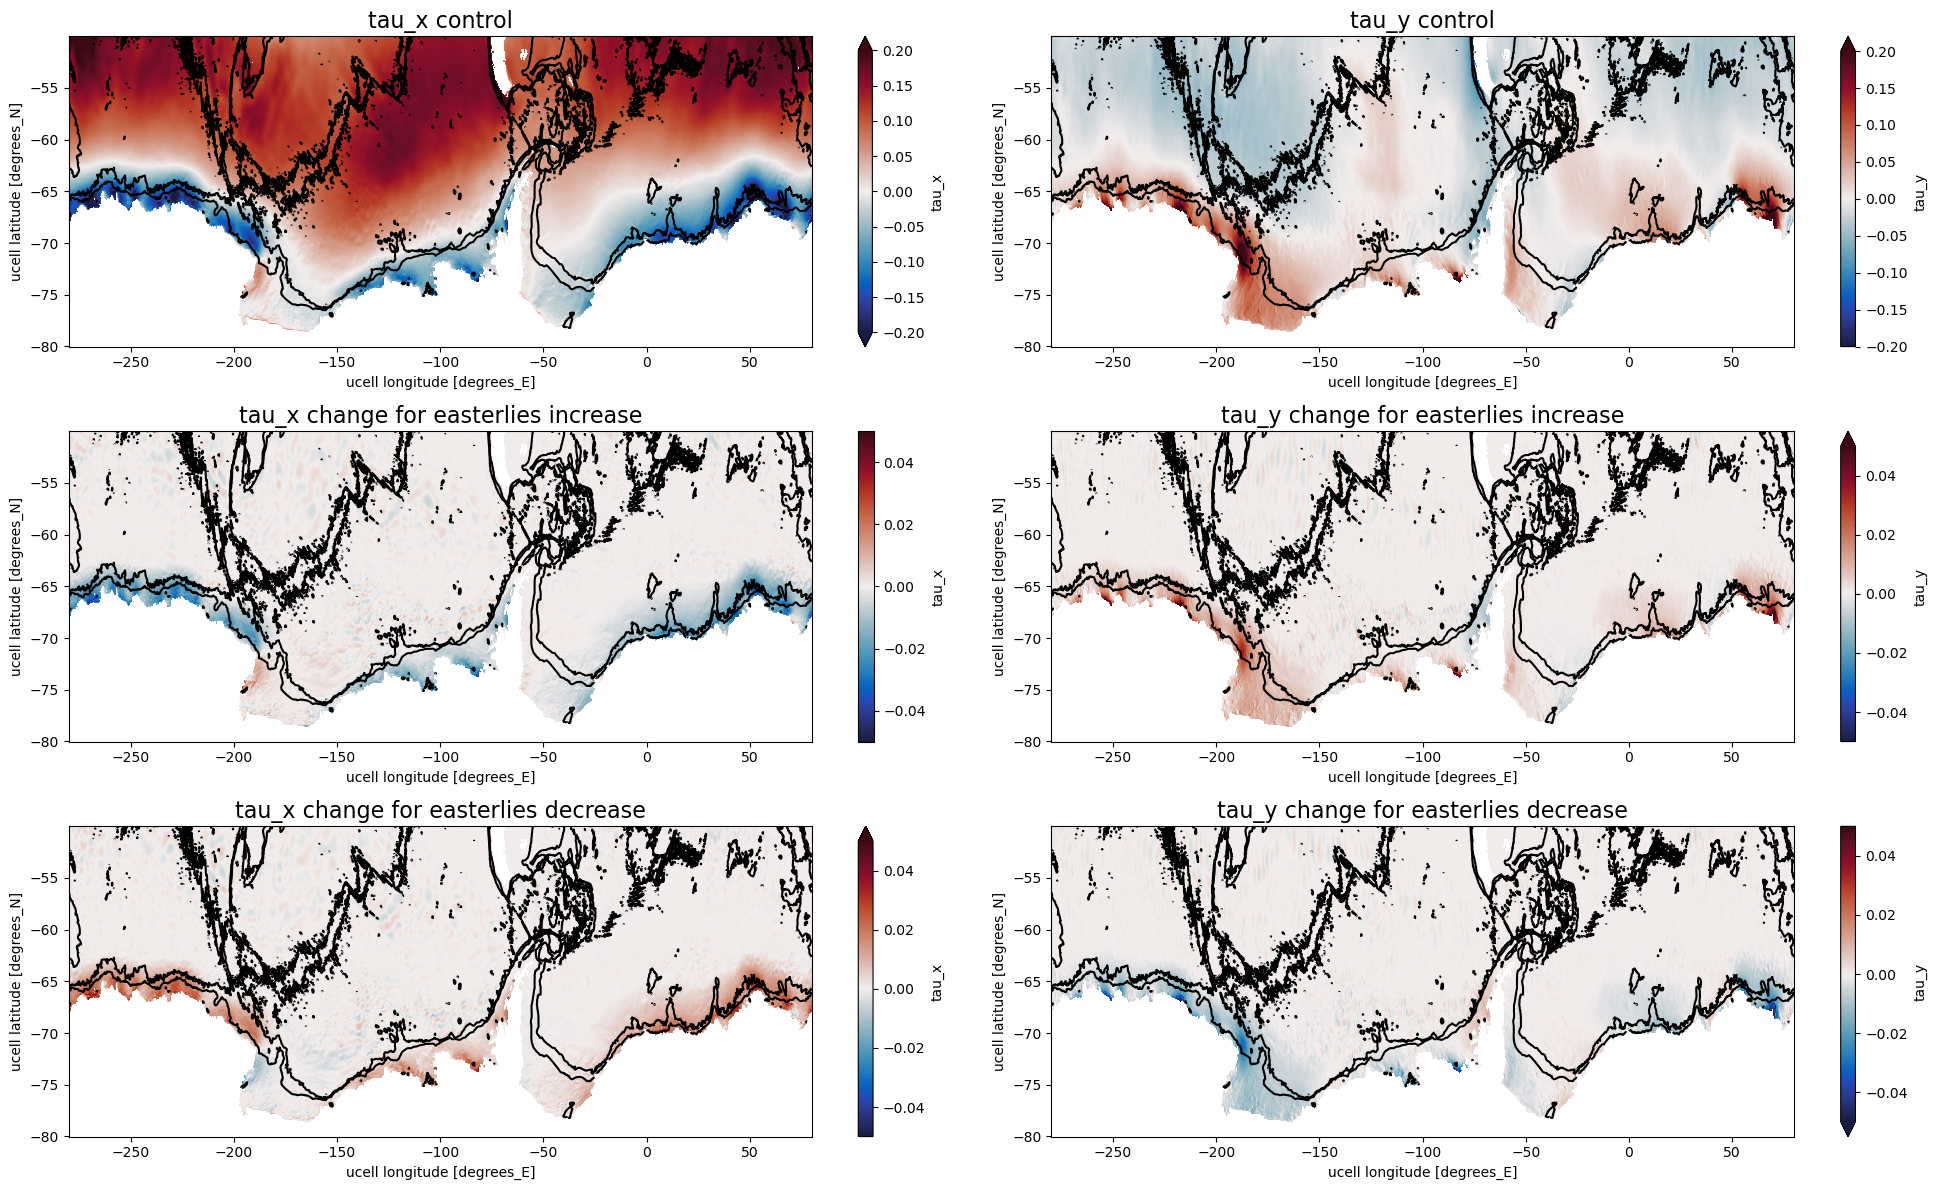

In [11]:
plt.figure(figsize=(20,12))

scale_max = 0.05

plt.subplot(3,2,1)
(tau_x_con).plot(vmin = -4*scale_max,vmax=4*scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_x control',fontsize=fontsize)

plt.subplot(3,2,2)
(tau_y_con).plot(vmin = -4*scale_max,vmax=4*scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_y control',fontsize=fontsize)

plt.subplot(3,2,3)
(tau_x_up - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_x change for easterlies increase',fontsize=fontsize)

plt.subplot(3,2,4)
(tau_y_up - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_y change for easterlies increase',fontsize=fontsize)

plt.subplot(3,2,5)
(tau_x_down - tau_x_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_x change for easterlies decrease',fontsize=fontsize)

plt.subplot(3,2,6)
(tau_y_down - tau_y_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('tau_y change for easterlies decrease',fontsize=fontsize)

plt.tight_layout()

## Plot 200m and bottom temperature change:

In [13]:
depth_slice = 200
lat_slice  = slice(-79,-59)

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             
temp_con_200m = temp_con.sel(st_ocean=depth_slice,method='nearest')
temp_con_200m = temp_con_200m.load()

temp_up = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_up = temp_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             
temp_up_200m = temp_up.sel(st_ocean=depth_slice,method='nearest')
temp_up_200m = temp_up_200m.load()

temp_down = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_down = temp_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             
temp_down_200m = temp_down.sel(st_ocean=depth_slice,method='nearest')
temp_down_200m = temp_down_200m.load()

# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_up = temp_up.where(depth_array.st_ocean >= max_depth)
bottom_temp_up = bottom_temp_up.sum(dim = 'st_ocean')
bottom_temp_up = bottom_temp_up.load()

bottom_temp_down = temp_down.where(depth_array.st_ocean >= max_depth)
bottom_temp_down = bottom_temp_down.sum(dim = 'st_ocean')
bottom_temp_down = bottom_temp_down.load()

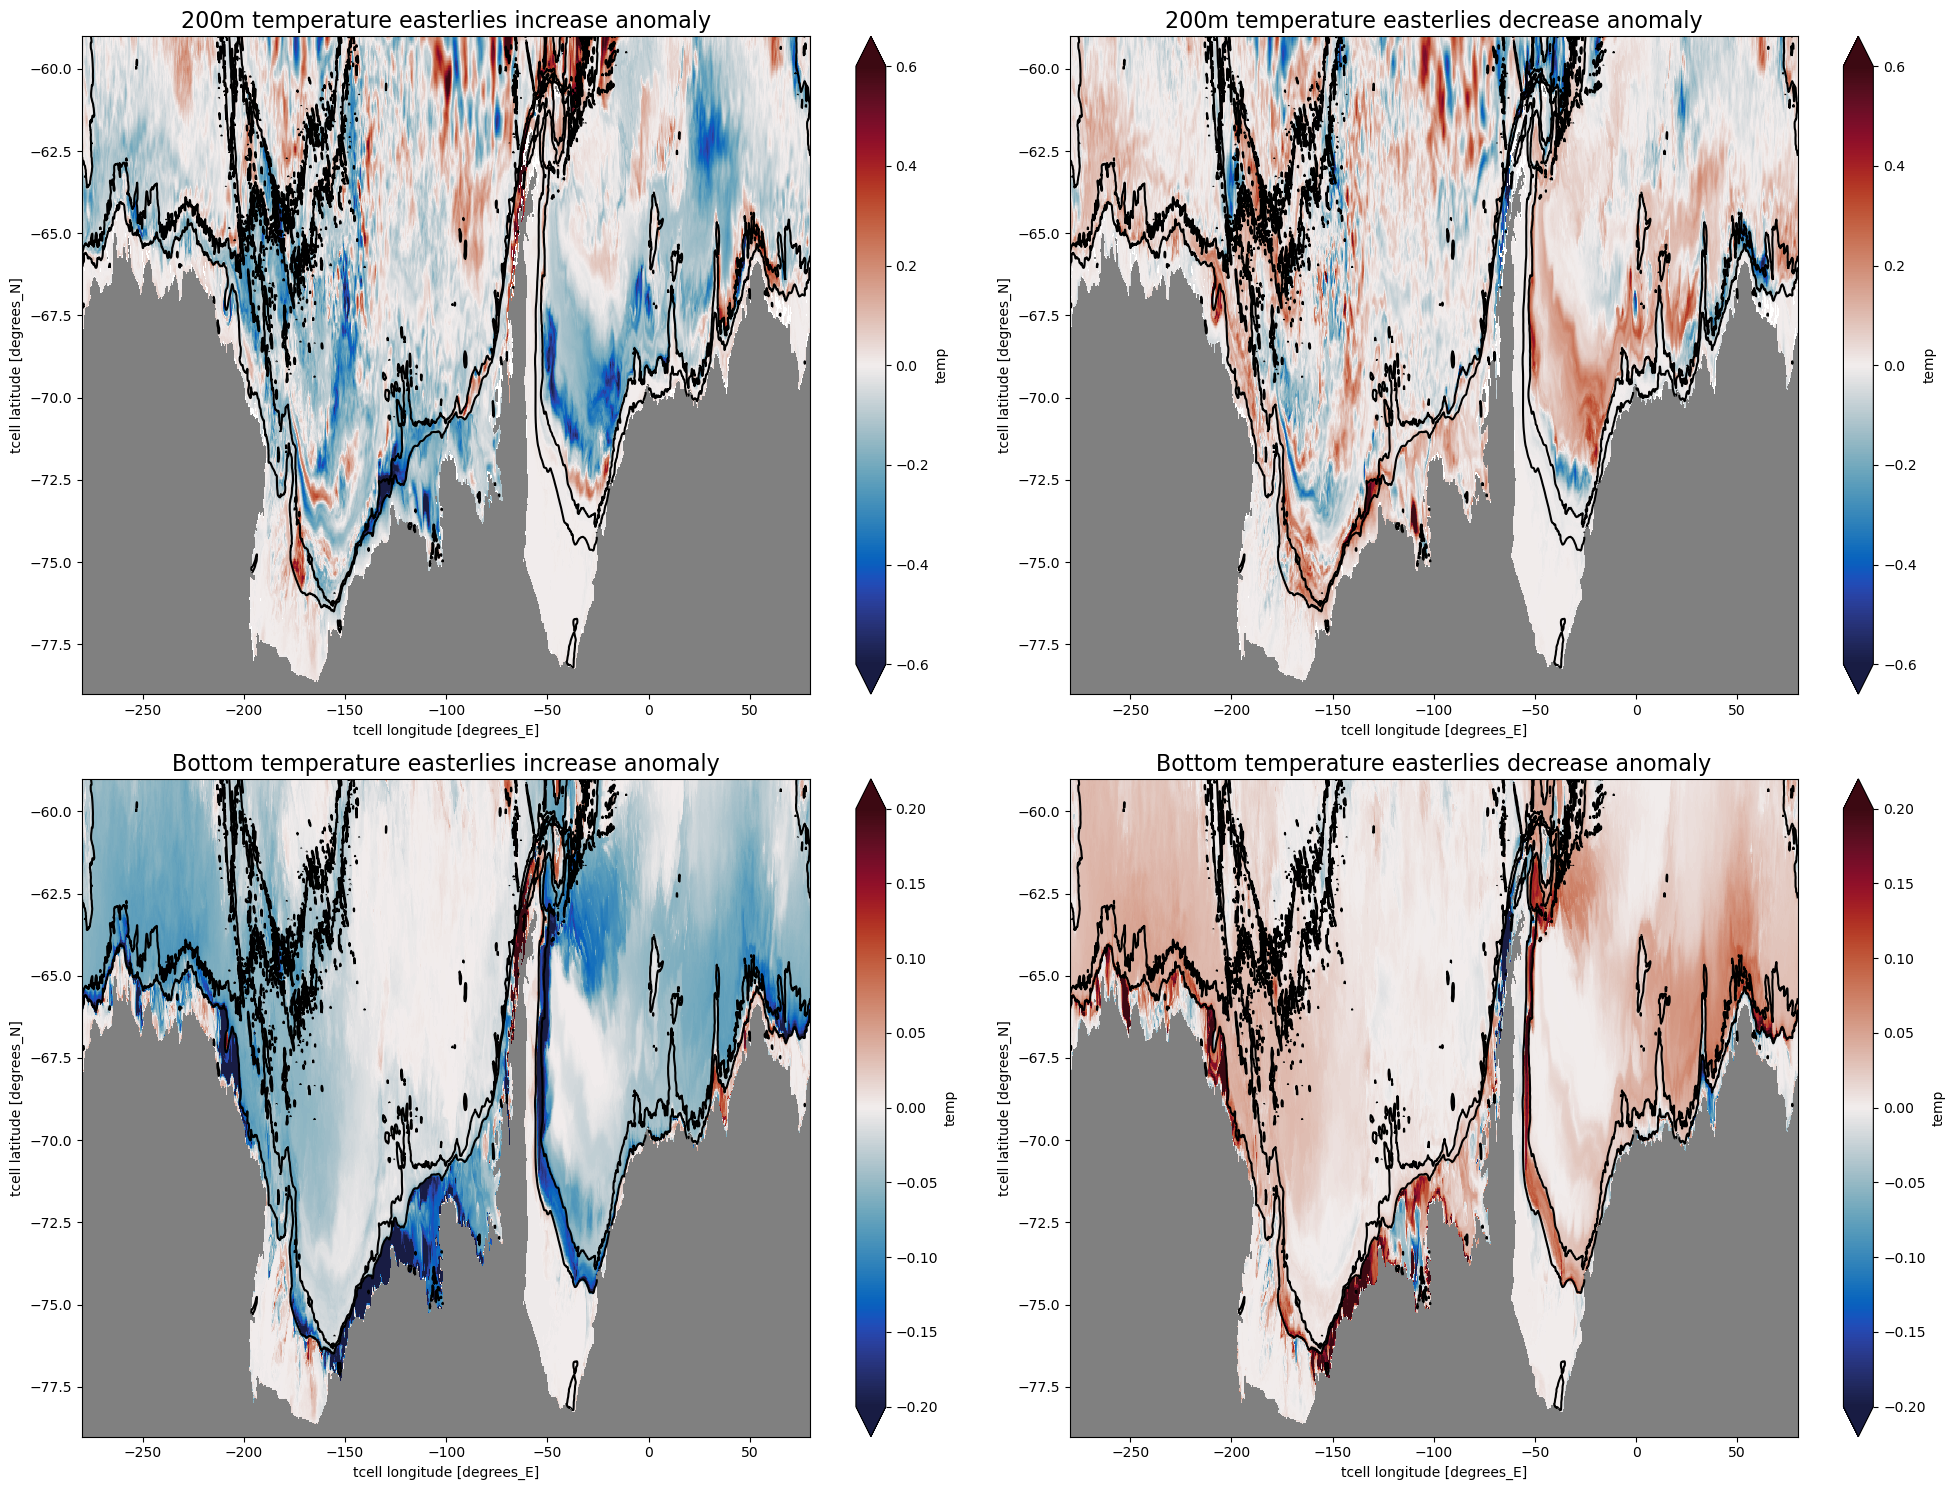

In [20]:
plt.figure(figsize=(20,15))

scale_max = 0.2

plt.subplot(2,2,1)
(temp_up_200m-temp_con_200m).plot(vmin = -3*scale_max,vmax=3*scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('200m temperature easterlies increase anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

plt.subplot(2,2,2)
(temp_down_200m-temp_con_200m).plot(vmin = -3*scale_max,vmax=3*scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('200m temperature easterlies decrease anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

plt.subplot(2,2,3)
(bottom_temp_up - bottom_temp_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('Bottom temperature easterlies increase anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

plt.subplot(2,2,4)
(bottom_temp_down - bottom_temp_con).plot(vmin = -scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k')
plt.title('Bottom temperature easterlies decrease anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

plt.tight_layout()